In [1]:
!pip install tensorflow==2.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 56.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0

In [2]:
import os
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
from glob import glob
from tqdm import tqdm
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, UpSampling2D, AveragePooling2D, MaxPooling2D, LeakyReLU, concatenate
from tensorflow.keras.layers import Flatten, Dense, MaxPool2D, ReLU, BatchNormalization, Concatenate, Lambda, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping

2023-08-05 18:11:19.975188: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-package

In [3]:
print(tf.__version__)
print(np.__version__)
print(cv2.__version__)

2.10.1
1.23.5
4.8.0


In [4]:
#Global variable
BATCH_SIZE = 16
W,H = 256, 256
CHANNEL = 3
lr = 1e-5
epochs = 100

In [5]:
model_path = "attn-unet_for_skull_stripping.h5"
csv_path = "atten-unet_for_skull_stripping.csv"
path = "/kaggle/input/skull-stripping/temp"
split = 0.1

# Evaluation Metrics

In [6]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection  + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [7]:
#create folder for save augmented images
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Function for data preprocessing

In [8]:
#load dataset
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")), key=lambda x: int(re.search(r'\d+', x).group()))
    masks = sorted(glob(os.path.join(path, "mask/*")), key=lambda x: int(re.search(r'\d+', x).group()))

    return images, masks

In [9]:
#process image function
def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256, 256))
    img = img / 255
    img = img.astype(np.float32)
    return img

#process mask function
def read_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255
    mask = np.expand_dims(mask, axis=-1)
    mask = mask.astype(np.float32)
    return mask

In [10]:
#enable to apply cv
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_img(x)
        y = read_mask(y)
        return x, y

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])

    return image, mask

In [11]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

# Model - Attention UNet

In [12]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [13]:
def attention_layer(g, s, num_filters):
    wg = Conv2D(num_filters, 1, padding='same')(g)
    wg = BatchNormalization()(wg)
    
    ws = Conv2D(num_filters, 1, padding='same')(s)
    ws = BatchNormalization()(ws)
    
    out = Activation('relu')(wg + ws)
    out = Conv2D(num_filters, 1, padding='same')(out)
    out = Activation('sigmoid')(out)
    
    return out 

In [14]:
def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

In [15]:
def decoder_block(x, s, num_filters):
    x = UpSampling2D(interpolation='bilinear')(x)
    s = attention_layer(x, s, num_filters)
    x = Concatenate()([x,s])
    x = conv_block(x, num_filters)
    return x

In [16]:
def attention_unet(input_shape):
    inputs = Input(input_shape)
    
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    b1 = conv_block(p4, 1024)
    
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)
    model = Model(inputs, outputs, name='Attn-Unet')
    
    return model

In [17]:
inputs = (256, 256, 3)
model = attention_unet(inputs)
model.summary()

Model: "Attn-Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

In [18]:
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

In [19]:
images, masks = load_data(path)
print(f'image: {len(images)} - Masks: {len(masks)}')

image: 722 - Masks: 722


In [20]:
train_image = images
train_masks = masks
test_image = images[700:]
test_masks = masks[700:]
print(f'image: {len(train_image)} - Masks: {len(train_masks)}')
print(f'image: {len(test_image)} - Masks: {len(test_masks)}')

image: 722 - Masks: 722
image: 22 - Masks: 22


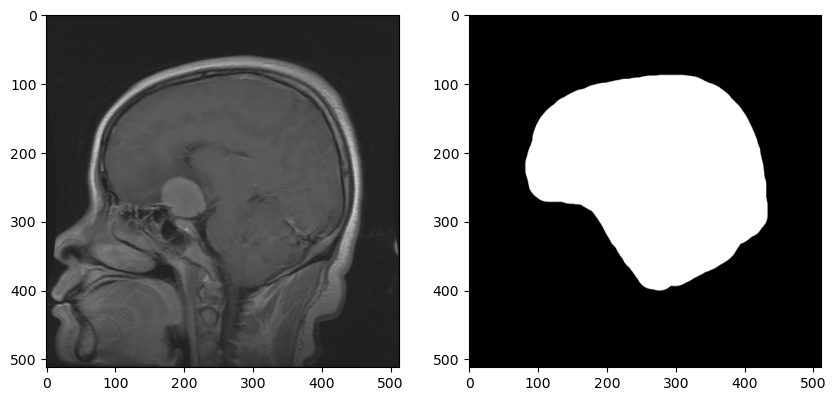

In [21]:
n = 200
img = cv2.imread(train_image[n], cv2.IMREAD_COLOR)
msk = cv2.imread(train_masks[n], cv2.IMREAD_COLOR)

fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(img)
ax[1].imshow(msk)

In [22]:
#convert dataset into tf dataset
train_dataset = tf_dataset(train_image, train_masks, batch=BATCH_SIZE)
test_dataset = tf_dataset(test_image, test_masks, batch=BATCH_SIZE)

In [23]:
#Callbacks
Callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True), 
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

In [24]:
#training
model.fit(
    train_dataset,
    epochs=35,
    validation_data=test_dataset, 
    callbacks=Callbacks
    )

Epoch 1/35
46/46 [==============================] - ETA: 0s - loss: 0.3852 - dice_coef: 0.6176 - iou: 0.4532 - recall: 0.9892 - precision: 0.5585
Epoch 1: val_loss improved from inf to 0.66698, saving model to attn-unet_for_skull_stripping.h5
46/46 [==============================] - 45s 677ms/step - loss: 0.3852 - dice_coef: 0.6176 - iou: 0.4532 - recall: 0.9892 - precision: 0.5585 - val_loss: 0.6670 - val_dice_coef: 0.3294 - val_iou: 0.1972 - val_recall: 1.0000 - val_precision: 0.2426 - lr: 1.0000e-05
Epoch 2/35
46/46 [==============================] - ETA: 0s - loss: 0.2352 - dice_coef: 0.7652 - iou: 0.6202 - recall: 0.9828 - precision: 0.8742
Epoch 2: val_loss did not improve from 0.66698
46/46 [==============================] - 26s 563ms/step - loss: 0.2352 - dice_coef: 0.7652 - iou: 0.6202 - recall: 0.9828 - precision: 0.8742 - val_loss: 0.6753 - val_dice_coef: 0.3215 - val_iou: 0.1916 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-05
Epoch 3/35
46/46 [========

# Load the Model

In [25]:
with CustomObjectScope({'iou':iou, 'dice_coef':dice_coef, 'dice_loss':dice_loss}):
    model = tf.keras.models.load_model("/kaggle/working/attn-unet_for_skull_stripping.h5")

In [26]:
path = "/kaggle/working/predicted"
create_dir(path)

# Prediction

In [27]:
for img, msk in tqdm(zip(test_image, test_masks), total=len(test_image)):
    image_name = img.split("/")[-1]

    ori_x = cv2.imread(img, cv2.IMREAD_COLOR)
    ori_x = cv2.resize(ori_x, (W,H))
    x = ori_x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    ori_y = cv2.imread(msk, cv2.IMREAD_GRAYSCALE)
    ori_y = cv2.resize(ori_y, (W,H))
    ori_y = np.expand_dims(ori_y, axis=-1)

    y_pred = model.predict(x)[0] > 0.5  
    y_pred = y_pred.astype(np.int32)
    y_pred = y_pred.reshape(256, 256, 1)

    print(ori_x.shape, ori_y.shape, y_pred.shape)
    save_image_path = f"/kaggle/working/predicted/{image_name}"

    sep_line = np.ones((H, 10, 3)) * 255
    cat_image = np.concatenate([ori_y, y_pred*255], axis=1)
    cv2.imwrite(save_image_path, cat_image)

  0%|          | 0/22 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  5%|▍         | 1/22 [00:01<00:25,  1.23s/it]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 27ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 3/22 [00:01<00:07,  2.63it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 28ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 5/22 [00:01<00:03,  4.37it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 26ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 7/22 [00:01<00:02,  5.97it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 26ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 27ms/step


 41%|████      | 9/22 [00:01<00:01,  7.27it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 26ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 25ms/step


 50%|█████     | 11/22 [00:02<00:01,  8.44it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 26ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 13/22 [00:02<00:00,  9.23it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 27ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 15/22 [00:02<00:00,  9.92it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 25ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 17/22 [00:02<00:00, 10.42it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 32ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 19/22 [00:02<00:00, 10.83it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 26ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 21/22 [00:02<00:00, 11.15it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 27ms/step


100%|██████████| 22/22 [00:03<00:00,  7.29it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)


Text(0.5, 0, 'truth                                     predicted')

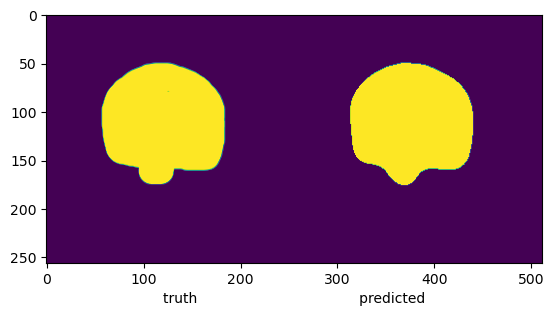

In [28]:
i = "/kaggle/working/predicted/709.png"
i = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
plt.imshow(i)
plt.xlabel("truth                                     predicted")

In [29]:
t_path = "/kaggle/working/"
image_folder = sorted(glob(os.path.join(t_path, "predicted/*")))

# Visualize the Prediction

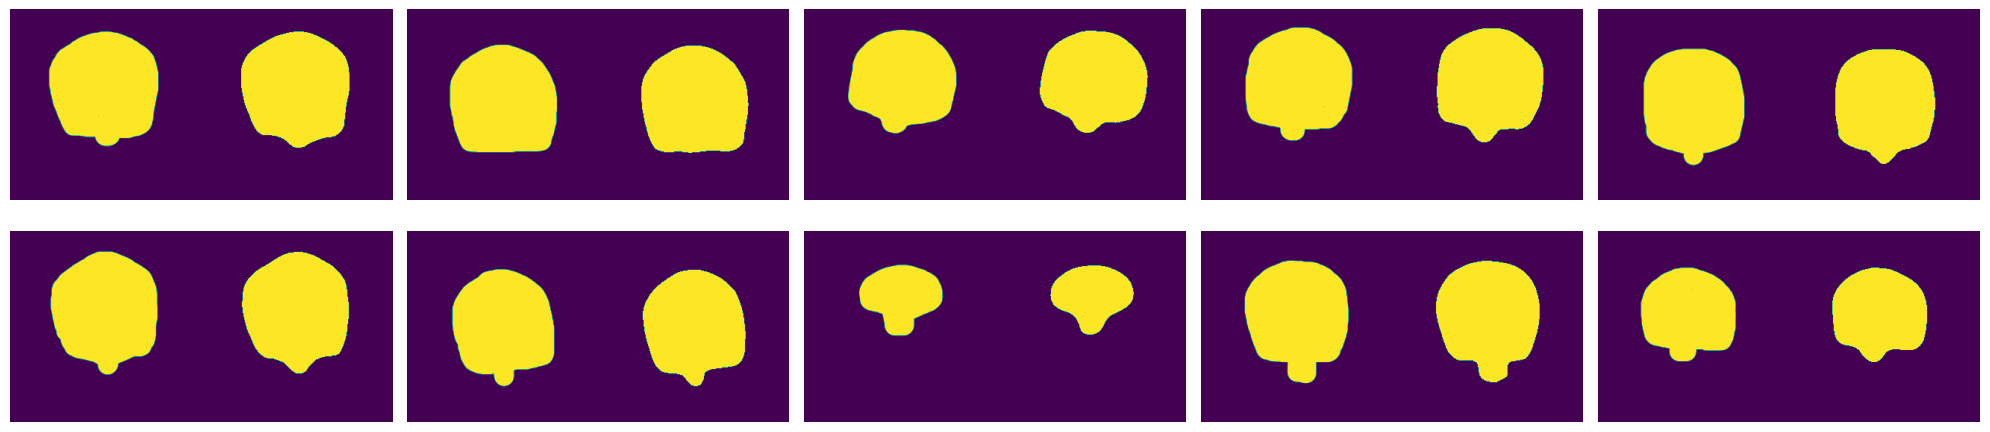

In [30]:
rows = 2
columns = 5

# Create a figure and axis objects
fig, axes = plt.subplots(rows, columns, figsize=(20, 5))

# Flatten the axes array to iterate through it easily
axes = axes.flatten()

# Loop through the images and display them
for i, ax in enumerate(axes):
    # Check if there are more images than needed for the grid
    if i < len(image_folder):
        # Read the image file
        image = mpimg.imread(image_folder[i])
        # Display the image
        ax.imshow(image)
        ax.axis("off")
    else:
        # If there are no more images, hide the remaining axes
        ax.axis("off")

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()

# Stripping the Skull

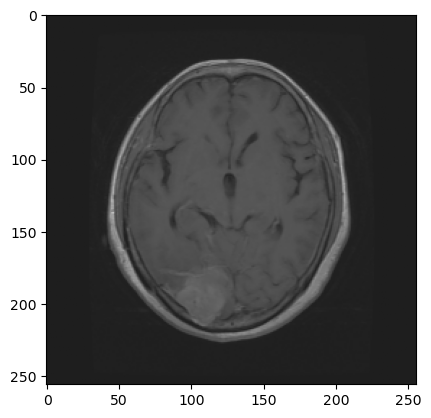

In [31]:
test_img_path = train_image[609]
test_img_mask = train_masks[609]
test_img = read_img(test_img_path)
test_msk = read_mask(test_img_mask)
plt.imshow(test_img)

In [32]:
img = test_img.reshape(1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [33]:
pred = model.predict(img)[0] > 0.5  
pred = pred.astype(np.int32)
pred_img = pred.reshape(256, 256, 1)

1/1 [==============================] - 0s 26ms/step


Text(0.5, 0, 'PREDICTED MASK')

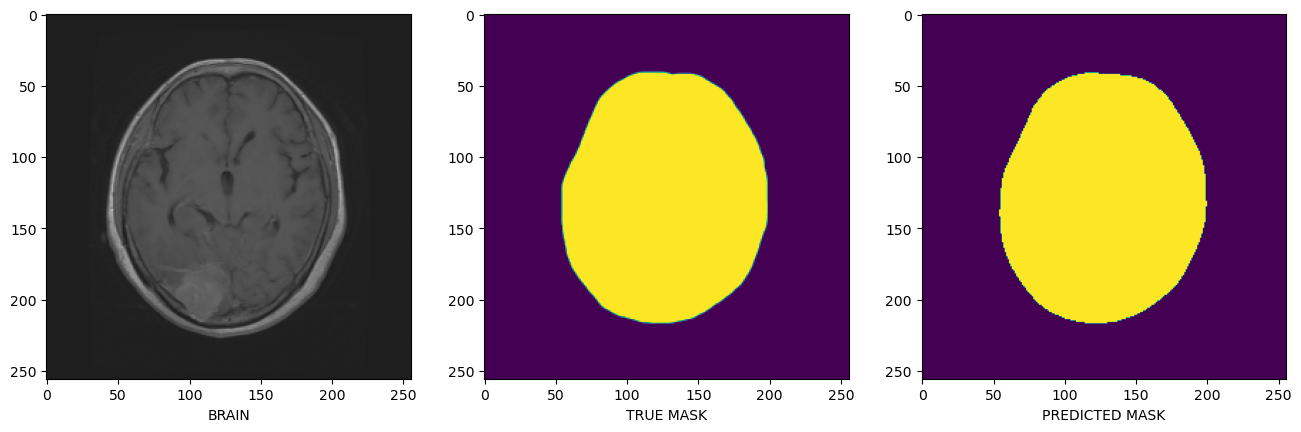

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(16,8))
ax[0].imshow(test_img)
ax[0].set_xlabel("BRAIN")
ax[1].imshow(test_msk)
ax[1].set_xlabel("TRUE MASK")
ax[2].imshow(pred_img)
ax[2].set_xlabel("PREDICTED MASK")

In [35]:
#save the predicted mask image
cv2.imwrite("/kaggle/working/mask-1.png", pred_img)

True

In [36]:
#read mask again
maskImg = cv2.imread("/kaggle/working/mask-1.png")
print(maskImg.shape)
maskImg = cv2.cvtColor(maskImg, cv2.COLOR_BGR2GRAY)
maskImg.shape

(256, 256, 3)


(256, 256)

In [37]:
# Bitwise AND the masked brain image with the masked image to remove the skull
masked = cv2.bitwise_and(test_img, test_img, mask=maskImg)

Text(0.5, 0, 'SKULL STRIPPED BRAIN')

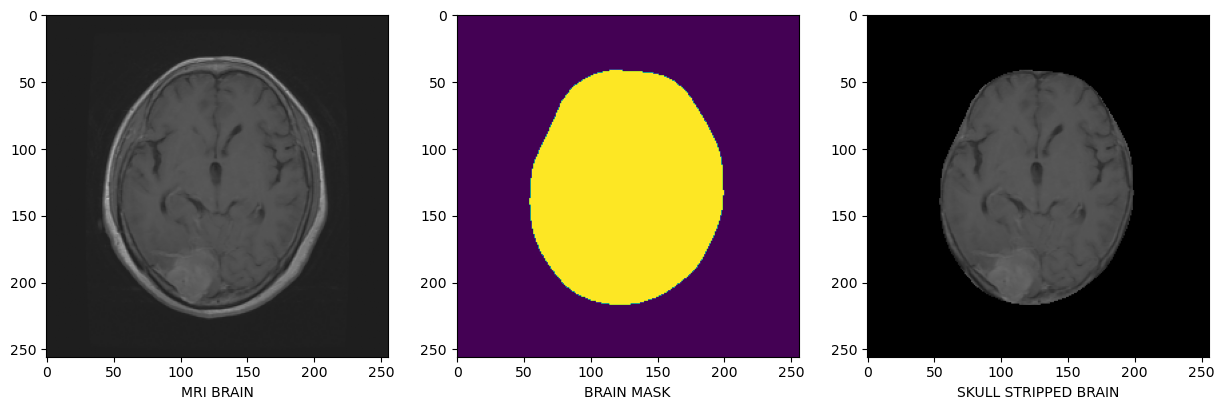

In [38]:
#visualize
fig, ax = plt.subplots(1, 3, figsize=(15, 12))
ax[0].imshow(test_img)
ax[0].set_xlabel("MRI BRAIN")
ax[1].imshow(maskImg)
ax[1].set_xlabel("BRAIN MASK")
ax[2].imshow(masked)
ax[2].set_xlabel("SKULL STRIPPED BRAIN")